<a href="https://colab.research.google.com/github/OchirnyamB/PoemGPT/blob/main/ob2367_PoemGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt

In [61]:
# Hyperparameters
# block_size = 8 # context length
# batch_size = 4 # number of sequences per batch
# num_heads = 2 # number of attention heads
# num_layers = 2 # transformer blocks
# embedding_dim = 32

# Increasing model capacity
block_size = 64 # context length
batch_size = 8 # number of sequences per batch
num_heads = 6 # number of attention heads
num_layers = 6 # transformer blocks
embedding_dim = 128

In [46]:
import pandas as pd
import csv
import sys
import re

# Load CSV
csv.field_size_limit(sys.maxsize)
df = pd.read_csv("genius_lyrics.csv", sep=None, engine='python')

# Rename first column as lyrics
df.columns = ['lyrics'] + [f"col_{i}" for i in range(1, len(df.columns))]

# Ensure all entries are string type
df['lyrics'] = df['lyrics'].astype(str)

# Filter for love-themed lyrics
df = df[df['lyrics'].str.contains("love", case=False)]
df = df[df['lyrics'].str.len() > 100]

# Clean the lyrics text
def clean(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Join lyrics
text = "\n<EOS>\n".join([clean(lyric) for lyric in df['lyrics']])

# Limitting to 10,000 words for ease of training
words = text.split()
limited_text = " ".join(words[:10_000])
print(limited_text[:500])


with open("lyrics.txt", "w", encoding="utf-8") as f:
    f.write(limited_text)

print(f"✅ Saved {len(limited_text.split())} words to lyrics.txt")

i wanna love you sideways back of the car and 100 miles on the highway that s only if we make it out of the driveway all that you give me all that you make me nobody knows me better all the highs and the lows when i m under pressure nobody else can put me back together only you build me only you break me if you keep your hands on me i m hoping that the world won t feel so lost and broken and i will love you i will keep you safe in my arms and if you love me you will keep a space in your heart fo
✅ Saved 10000 words to lyrics.txt


In [45]:
# import os
# import re

# # ========== Configuration of scraped dataset using lyrics books ==========
# input_dir = "sample_data"     # Folder containing .txt files (poems, lyrics, etc.)
# output_file = "lyrics.txt"       # Output file to use for training
# eos_token = "<EOS>"

# # Load all texts from a poem or lyrics books.
# all_text = []

# def clean(text):
#     text = text.lower()
#     text = re.sub(r'\*\*\*.*?\*\*\*', '', text)  # Remove Gutenberg headers/footers
#     text = re.sub(r'lines longer than.*?broken.*?\.', '', text)  # Remove formatting notes
#     text = re.sub(r'(produced by|project gutenberg).*?\.', '', text)
#     text = re.sub(r'[^a-z0-9.,;:!?\n\'" ]+', ' ', text)
#     text = re.sub(r'\s+', ' ', text)
#     text = re.sub(r' ?\n ?', '\n', text)
#     return text.strip()

# for filename in os.listdir(input_dir):
#     if filename.endswith(".txt"):
#         path = os.path.join(input_dir, filename)
#         with open(path, "r", encoding="utf-8") as f:
#             text = f.read()
#             all_text.append(clean(text))


# cleaned = f"\n{eos_token}\n".join(all_text)


# with open(output_file, "w", encoding="utf-8") as f:
#     f.write(cleaned)

# print("✅ Training dataset prepared.")
# print(f"Total characters: {len(cleaned):,}")
# print(f"Saved to: {output_file}")
# print("\nPreview:\n" + "-"*40)
# print(cleaned[:1000])

✅ Training dataset prepared.
Total characters: 0
Saved to: lyrics.txt

Preview:
----------------------------------------



In [62]:
# Tokenization
import os
import re
import torch
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import ByteLevel


# ========= BPE tokenization =========
with open("lyrics.txt", "r", encoding="utf-8") as f:
    raw_text = f.read().lower()

# Optional cleaning
text = re.sub(r"[^a-z0-9.,;:!?'\" \n]", " ", raw_text)
text = re.sub(r"\s+", " ", text).strip()

# Save cleaned text
with open("bpe_corpus.txt", "w", encoding="utf-8") as f:
    f.write(text)

tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = ByteLevel()

os.makedirs("bpe_tokenizer", exist_ok=True)

tokenizer.train(
    files=["bpe_corpus.txt"],
    vocab_size=3000,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"]
)

tokenizer.save_model("bpe_tokenizer")

tokenizer = ByteLevelBPETokenizer(
    "bpe_tokenizer/vocab.json",
    "bpe_tokenizer/merges.txt"
)

tokenizer.enable_truncation(max_length=128)  # or whatever your block_size is
encode = lambda s: tokenizer.encode(s).ids
decode = lambda l: tokenizer.decode(l)

tokens = encode(text)
data = torch.tensor(tokens, dtype=torch.long)
vocab_size = tokenizer.get_vocab_size()

print(f"✅ Loaded {len(tokens):,} tokens, vocab size = {vocab_size}")
print("Example decoded:", decode(tokens[:50]))


# ========= Character Tokenization =========
# chars = sorted(set(cleaned))
# vocab_size = len(chars)
# stoi = {ch: i for i, ch in enumerate(chars)}
# itos = {i: ch for ch, i in stoi.items()}
# print("Token embedding", stoi)
# print("Token decoding", itos)

# # Encoding and Decoding
# encode = lambda s: [stoi[c] for c in s]
# decode = lambda l: ''.join([itos[i] for i in l])
# data = torch.tensor(encode(cleaned), dtype=torch.long)
# print(data[:100])


# ========= Word Tokenization =========
# words = cleaned.lower().split()
# most_common = Counter(words).most_common(10000)
# vocab = [word for word, _ in most_common]
# vocab_size = len(vocab)
# stoi = {w: i for i, w in enumerate(vocab)}
# itos = {i: w for w, i in stoi.items()}
# print("Token embedding", list(stoi.items())[:10])
# print("Token decoding", list(itos.items())[:10])

# encode = lambda s: [stoi.get(w, 0) for w in s.lower().split()]
# decode = lambda l: ' '.join([itos[i] for i in l])
# data = torch.tensor(encode(cleaned), dtype=torch.long)
# print(data[:100])



# =================== Batch Sampling ======================
def get_batch():
    if len(data) < block_size+1:
        raise ValueError(f"Dataset too small: block_size={block_size}, but got only {len(data)} tokens.")
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

# =================== Attention Head ======================
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()  # initialize base class

        # 3 separate linear layers for Q, K, V to compute attention weights and produce contextualized output for each token.
        # Input shape [batch_size, seq_len, embedding_dim]
        # Output shape [batch_size, seq_len, head_size]
        self.key = nn.Linear(embedding_dim, head_size, bias=False) # no addional bias terms
        self.query = nn.Linear(embedding_dim, head_size, bias=False) # no addional bias terms
        self.value = nn.Linear(embedding_dim, head_size, bias=False) # no addional bias terms
        self.dropout = nn.Dropout(0.1) # apply dropout with probability of 10%

    def forward(self, x):
      B, T, C = x.shape  # (batch_size x seq_len x embedding_dim) [4, 8, 32]
      k = self.key(x)    # (B x T x head_size) [4, 8, 16]
      q = self.query(x)  # [4, 8, 16]
      v = self.value(x)  # [4, 8, 16]

      # ==== Scaled Dot Product Attention =====
      wei = q @ k.transpose(-2, -1) / (C ** 0.5)  # [4, 8, 8] — attention scores, prevent large values in the softmax and stabilize gradient
      wei = F.softmax(wei, dim=-1)                # [4, 8, 8] — attention weights, how each token should pay attention to others, one for each position in the sequence B x T x T
      wei = self.dropout(wei)
      out = wei @ v                               # [4, 8, 16] — attention output (B x T x head_size) of a single head
      return out


# =================== Multi-head Attention ======================
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()  # initialize base class
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads*head_size, embedding_dim)  # compressing the multi-head result back into one uniform shape
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)      # each head returns tensor of shape [B x T x head_size] => B x T x num_heads * head_size
        out = self.proj(out)
        return out


# =================== Feedforward Network ======================
# 2 Layer token wise MLP
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()  # initialize base class
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.ReLU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.net(x)

# =================== Transformer Block ======================
class Block(nn.Module):
    def __init__(self):
        super().__init__()  # initialize base class
        head_size = embedding_dim // num_heads
        self.attn = MultiHeadAttention(num_heads, head_size)
        self.ffwd = FeedForward()
        self.ln1 = nn.LayerNorm(embedding_dim)    # helps stabilize training
        self.ln2 = nn.LayerNorm(embedding_dim)    # normalize per token vector

    def forward(self, x):
        x = x + self.attn(self.ln1(x))            # residual connection, allows the model to learn context without overwriting
        x = x + self.ffwd(self.ln2(x))
        return x                                  # [B x T x embedding_dim]


# =================== GPT Model ======================
class GPT(nn.Module):
    def __init__(self):
        super().__init__()  # initialize base class
        self.token_embed = nn.Embedding(vocab_size, embedding_dim)  # look up the embedding lookup table for each token ID
        self.pos_embed = nn.Embedding(block_size, embedding_dim)
        self.blocks = nn.Sequential(*[Block() for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, vocab_size)

    def forward(self, idx):
        B,T = idx.shape
        tok_emb = self.token_embed(idx)  # shape: [B, T, embedding_dim]
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_embed(pos)    # shape: [T, embedding_dim]
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)            # self.blocks or multi-had attention blocks give me 32D rich contextual embeddings, collapsing to vocab size
        return logits                    # [B, T, vocab_size]

    def generate(self, idx, max_new_tokens=200, temperature=1.0, top_k=50, reptition_penalty=1.2):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]  # only feed the last block_size tokens into the model (important if sequence is growing beyond context length). Don't work on future tokens
            logits = self(idx_cond)          # [B, T, vocab_size]
            logits = logits[:, -1, :]

            # Apply repetition penalty
            for b in range(idx.size(0)):
                for token in set(idx[b].tolist()):
                    logits[b, token] /= repetition_penalty

            # Softmax
            probs = F.softmax(logits / temperature, dim=-1)

            # Top-k filtering
            if top_k is not None:
                top_k_values, _ = torch.topk(probs, top_k)
                probs[probs < top_k_values[:, -1, None]] = 0
                probs /= probs.sum(dim=-1, keepdim=True)

            # Sample
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

✅ Loaded 128 tokens, vocab size = 1691
Example decoded: i wanna love you sideways back of the car and 100 miles on the highway that s only if we make it out of the driveway all that you give me all that you make me nobody knows me better all the highs and the


Input → LayerNorm → Multi-Head Attention → +Residual →
       → LayerNorm → Feedforward MLP     → +Residual → Output

Epoch 0, Loss: 7.4866
Epoch 20, Loss: 6.3644
Epoch 40, Loss: 5.6722
Epoch 60, Loss: 5.0012
Epoch 80, Loss: 4.3616
Epoch 100, Loss: 3.6532
Epoch 120, Loss: 3.1848
Epoch 140, Loss: 2.6603
Epoch 160, Loss: 2.3004
Epoch 180, Loss: 1.8998
Epoch 200, Loss: 1.6874
Epoch 220, Loss: 1.7565
Epoch 240, Loss: 1.3481
Epoch 260, Loss: 1.2853
Epoch 280, Loss: 1.2164
Epoch 300, Loss: 1.2371
Epoch 320, Loss: 1.0773
Epoch 340, Loss: 0.9076
Epoch 360, Loss: 0.9123
Epoch 380, Loss: 0.7772
Epoch 400, Loss: 0.7738
Epoch 420, Loss: 0.6933
Epoch 440, Loss: 0.6228
Epoch 460, Loss: 0.5601
Epoch 480, Loss: 0.4874
Epoch 500, Loss: 0.4898
Epoch 520, Loss: 0.4672
Epoch 540, Loss: 0.4411
Epoch 560, Loss: 0.3430
Epoch 580, Loss: 0.3665
Epoch 600, Loss: 0.3111
Epoch 620, Loss: 0.3079
Epoch 640, Loss: 0.2816
Epoch 660, Loss: 0.2869
Epoch 680, Loss: 0.2761
Epoch 700, Loss: 0.2679
Epoch 720, Loss: 0.2553
Epoch 740, Loss: 0.2311
Epoch 760, Loss: 0.2234
Epoch 780, Loss: 0.2254
Epoch 800, Loss: 0.2047
Epoch 820, Loss: 0.171

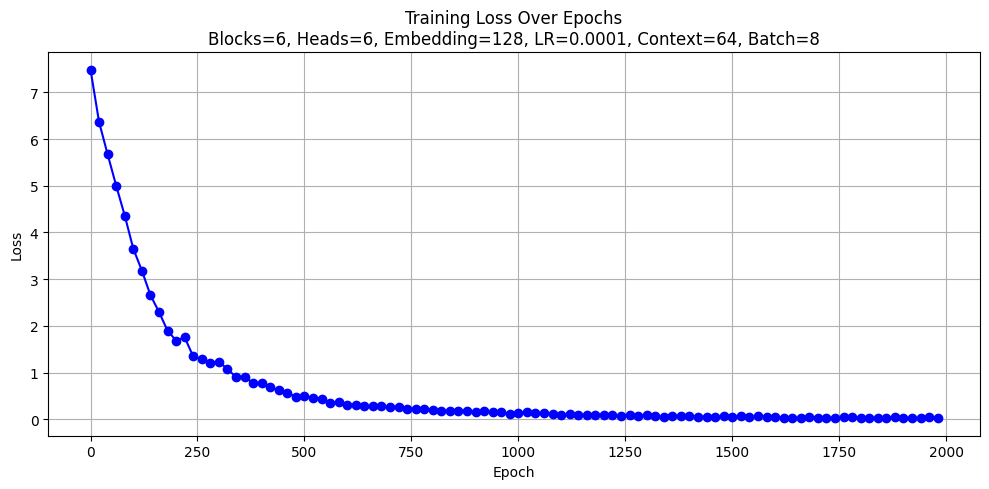

In [73]:
# =================== Training Loop ======================

block_size = 64 # context length
batch_size = 8 # number of sequences per batch
num_heads = 6 # number of attention heads
num_layers = 6 # transformer blocks
embedding_dim = 128
learning_rate = 1e-4
num_epochs = 2000
model = GPT()
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
losses = []

for epoch in range(num_epochs):
   xb, yb = get_batch()  # [batch_size, block_size]
   logits = model(xb)    # [B, T, vocab_size]
   B,T,C = logits.shape  # C = vocab_size
   loss = F.cross_entropy(logits.view(B*T,C), yb.view(B*T))   # [B*T, C] -> [B,T] to match with ground truth label, that's why cross entropy
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   if epoch % 20 == 0:
      print(f"Epoch {epoch}, Loss: {loss.item():0.4f}")
      losses.append(loss.item())


# =================== Results ======================
context = torch.tensor(encode("i miss you and"), dtype=torch.long).unsqueeze(0)
print("\nGenerated Lyrics:")
tokens = model.generate(context, max_new_tokens=100, temperature=0.8, top_k=40)[0].tolist()
decoded = decode(tokens)

# Optional: stop at <EOS>
if "<EOS>" in decoded:
    decoded = decoded.split("<EOS>")[0]

print(decoded.strip())

epochs = list(range(0, num_epochs, 20))[:len(losses)]  # match saved loss length
label = (
    f"Blocks={num_layers}, Heads={num_heads}, Embedding={embedding_dim}, "
    f"LR={learning_rate}, Context={block_size}, Batch={batch_size}"
)
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title("Training Loss Over Epochs\n" + label)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 0, Loss: 7.6009
Epoch 20, Loss: 5.0164
Epoch 40, Loss: 3.5016
Epoch 60, Loss: 2.4215
Epoch 80, Loss: 1.5483
Epoch 100, Loss: 1.0360
Epoch 120, Loss: 1.1422
Epoch 140, Loss: 0.6912
Epoch 160, Loss: 0.8854
Epoch 180, Loss: 0.4120
Epoch 200, Loss: 0.4156
Epoch 220, Loss: 0.4172
Epoch 240, Loss: 0.3936
Epoch 260, Loss: 0.2766
Epoch 280, Loss: 0.2324
Epoch 300, Loss: 0.2504
Epoch 320, Loss: 0.2872
Epoch 340, Loss: 0.1834
Epoch 360, Loss: 0.1508
Epoch 380, Loss: 0.1498
Epoch 400, Loss: 0.1368
Epoch 420, Loss: 0.1116
Epoch 440, Loss: 0.1198
Epoch 460, Loss: 0.1426
Epoch 480, Loss: 0.0860
Epoch 500, Loss: 0.0904
Epoch 520, Loss: 0.1036
Epoch 540, Loss: 0.0851
Epoch 560, Loss: 0.0543
Epoch 580, Loss: 0.0846
Epoch 600, Loss: 0.0492
Epoch 620, Loss: 0.0884
Epoch 640, Loss: 0.0658
Epoch 660, Loss: 0.0363
Epoch 680, Loss: 0.0986
Epoch 700, Loss: 0.0280
Epoch 720, Loss: 0.0543
Epoch 740, Loss: 0.0151
Epoch 760, Loss: 0.0351
Epoch 780, Loss: 0.0770
Epoch 800, Loss: 0.0504
Epoch 820, Loss: 0.024

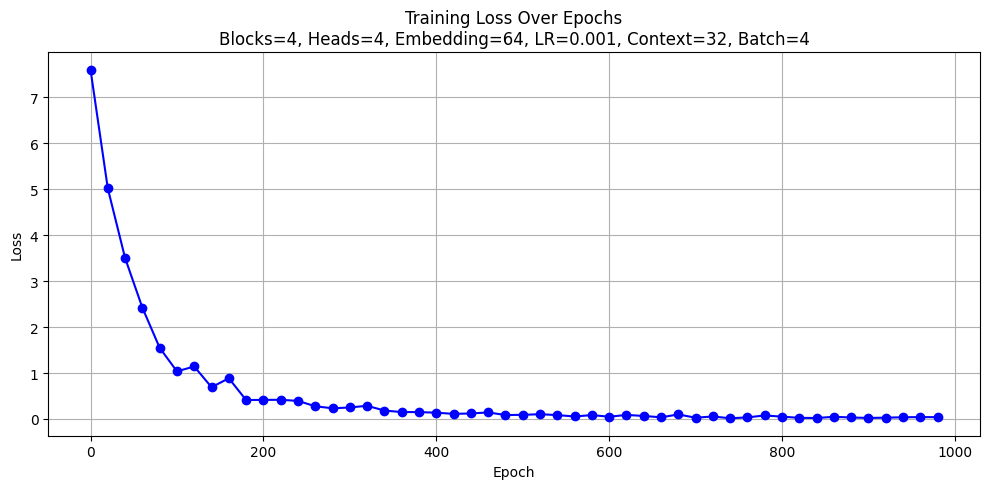

In [71]:
# =================== Training Loop ======================

block_size = 32 # context length
batch_size = 4 # number of sequences per batch
num_heads = 4 # number of attention heads
num_layers = 4 # transformer blocks
embedding_dim = 64
learning_rate = 1e-3
num_epochs = 1000
model = GPT()
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
losses = []

for epoch in range(num_epochs):
   xb, yb = get_batch()  # [batch_size, block_size]
   logits = model(xb)    # [B, T, vocab_size]
   B,T,C = logits.shape  # C = vocab_size
   loss = F.cross_entropy(logits.view(B*T,C), yb.view(B*T))   # [B*T, C] -> [B,T] to match with ground truth label, that's why cross entropy
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   if epoch % 20 == 0:
      print(f"Epoch {epoch}, Loss: {loss.item():0.4f}")
      losses.append(loss.item())


# =================== Results ======================
context = torch.tensor(encode("i miss you and"), dtype=torch.long).unsqueeze(0)
print("\nGenerated Lyrics:")
tokens = model.generate(context, max_new_tokens=100, temperature=0.8, top_k=40)[0].tolist()
decoded = decode(tokens)

# Optional: stop at <EOS>
if "<EOS>" in decoded:
    decoded = decoded.split("<EOS>")[0]

print(decoded.strip())

epochs = list(range(0, num_epochs, 20))[:len(losses)]  # match saved loss length
label = (
    f"Blocks={num_layers}, Heads={num_heads}, Embedding={embedding_dim}, "
    f"LR={learning_rate}, Context={block_size}, Batch={batch_size}"
)
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title("Training Loss Over Epochs\n" + label)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 0, Loss: 7.6872
Epoch 20, Loss: 4.1766
Epoch 40, Loss: 3.7087
Epoch 60, Loss: 2.1808
Epoch 80, Loss: 2.1042
Epoch 100, Loss: 0.8999
Epoch 120, Loss: 0.7117
Epoch 140, Loss: 0.5093
Epoch 160, Loss: 0.7820
Epoch 180, Loss: 0.5208
Epoch 200, Loss: 0.3826
Epoch 220, Loss: 0.4440
Epoch 240, Loss: 0.2912
Epoch 260, Loss: 0.1806
Epoch 280, Loss: 0.3980
Epoch 300, Loss: 0.1579
Epoch 320, Loss: 0.1869
Epoch 340, Loss: 0.3090
Epoch 360, Loss: 0.3662
Epoch 380, Loss: 0.1323
Epoch 400, Loss: 0.3085
Epoch 420, Loss: 0.1470
Epoch 440, Loss: 0.2886
Epoch 460, Loss: 0.1955
Epoch 480, Loss: 0.1520
Epoch 500, Loss: 0.0415
Epoch 520, Loss: 0.1127
Epoch 540, Loss: 0.1205
Epoch 560, Loss: 0.0925
Epoch 580, Loss: 0.0792
Epoch 600, Loss: 0.0460
Epoch 620, Loss: 0.0967
Epoch 640, Loss: 0.3567
Epoch 660, Loss: 0.1416
Epoch 680, Loss: 0.2719
Epoch 700, Loss: 0.0176
Epoch 720, Loss: 0.0909
Epoch 740, Loss: 0.0835
Epoch 760, Loss: 0.0275
Epoch 780, Loss: 0.0389
Epoch 800, Loss: 0.0811
Epoch 820, Loss: 0.070

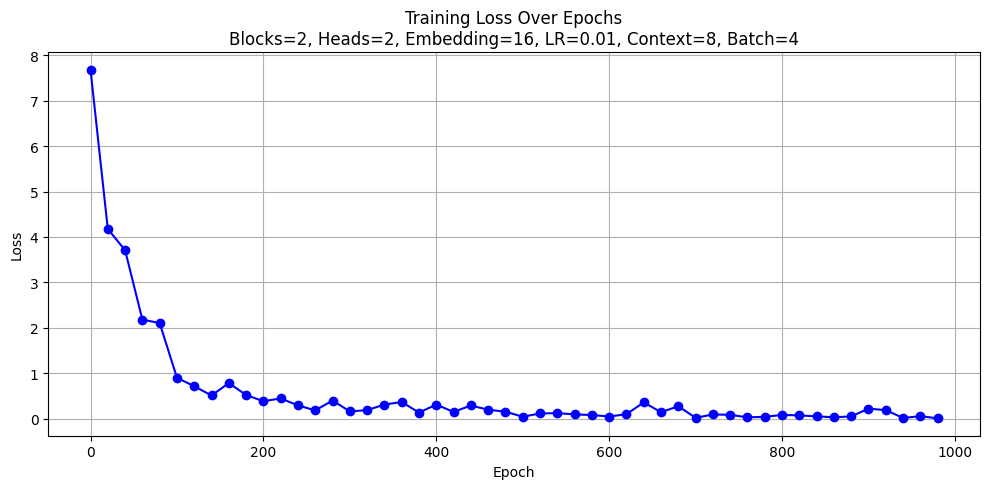

In [72]:
# =================== Training Loop ======================

block_size = 8 # context length
batch_size = 4 # number of sequences per batch
num_heads = 2 # number of attention heads
num_layers = 2 # transformer blocks
embedding_dim = 16
learning_rate = 1e-2
num_epochs = 1000
model = GPT()
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
losses = []

for epoch in range(num_epochs):
   xb, yb = get_batch()  # [batch_size, block_size]
   logits = model(xb)    # [B, T, vocab_size]
   B,T,C = logits.shape  # C = vocab_size
   loss = F.cross_entropy(logits.view(B*T,C), yb.view(B*T))   # [B*T, C] -> [B,T] to match with ground truth label, that's why cross entropy
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   if epoch % 20 == 0:
      print(f"Epoch {epoch}, Loss: {loss.item():0.4f}")
      losses.append(loss.item())


# =================== Results ======================
context = torch.tensor(encode("i miss you and"), dtype=torch.long).unsqueeze(0)
print("\nGenerated Lyrics:")
tokens = model.generate(context, max_new_tokens=100, temperature=0.8, top_k=40)[0].tolist()
decoded = decode(tokens)

# Optional: stop at <EOS>
if "<EOS>" in decoded:
    decoded = decoded.split("<EOS>")[0]

print(decoded.strip())

epochs = list(range(0, num_epochs, 20))[:len(losses)]  # match saved loss length
label = (
    f"Blocks={num_layers}, Heads={num_heads}, Embedding={embedding_dim}, "
    f"LR={learning_rate}, Context={block_size}, Batch={batch_size}"
)
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title("Training Loss Over Epochs\n" + label)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 0, Loss: 7.9132
Epoch 20, Loss: 5.4580
Epoch 40, Loss: 5.6117
Epoch 60, Loss: 4.9946
Epoch 80, Loss: 3.2311
Epoch 100, Loss: 3.6788
Epoch 120, Loss: 2.8460
Epoch 140, Loss: 2.4855
Epoch 160, Loss: 2.9373
Epoch 180, Loss: 2.3813
Epoch 200, Loss: 3.3384
Epoch 220, Loss: 2.3565
Epoch 240, Loss: 3.7776
Epoch 260, Loss: 3.3316
Epoch 280, Loss: 2.7341
Epoch 300, Loss: 4.9199
Epoch 320, Loss: 3.0653
Epoch 340, Loss: 1.8552
Epoch 360, Loss: 3.7284
Epoch 380, Loss: 0.8200
Epoch 400, Loss: 2.2167
Epoch 420, Loss: 1.6182
Epoch 440, Loss: 1.2142
Epoch 460, Loss: 1.1644
Epoch 480, Loss: 2.0302
Epoch 500, Loss: 2.2698
Epoch 520, Loss: 0.7191
Epoch 540, Loss: 2.4228
Epoch 560, Loss: 1.1772
Epoch 580, Loss: 1.8466
Epoch 600, Loss: 0.4797
Epoch 620, Loss: 0.6207
Epoch 640, Loss: 1.5325
Epoch 660, Loss: 0.3789
Epoch 680, Loss: 1.2923
Epoch 700, Loss: 1.5381
Epoch 720, Loss: 0.9566
Epoch 740, Loss: 0.6228
Epoch 760, Loss: 0.2056
Epoch 780, Loss: 2.1461
Epoch 800, Loss: 1.5609
Epoch 820, Loss: 0.813

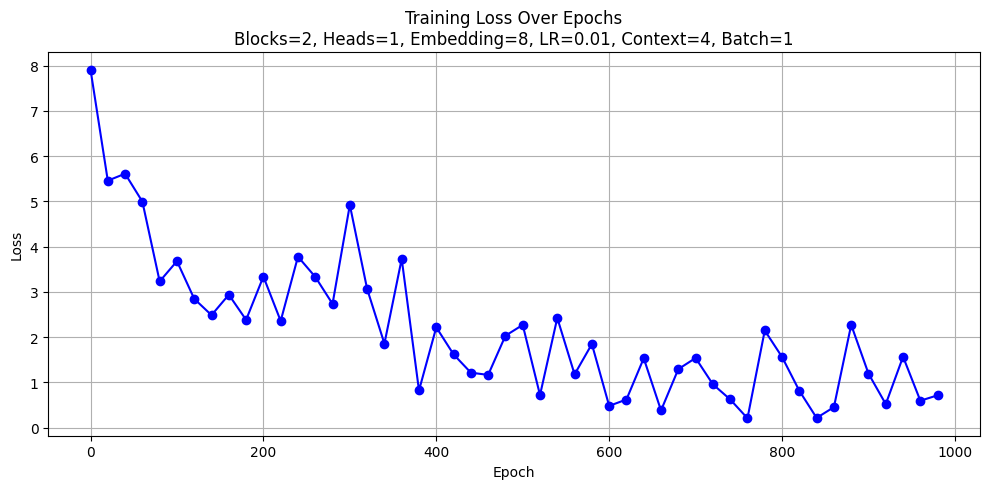

In [74]:
# =================== Training Loop ======================

block_size = 4 # context length
batch_size = 1 # number of sequences per batch
num_heads = 1 # number of attention heads
num_layers = 2 # transformer blocks
embedding_dim = 8
learning_rate = 1e-2
num_epochs = 1000
model = GPT()
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
losses = []

for epoch in range(num_epochs):
   xb, yb = get_batch()  # [batch_size, block_size]
   logits = model(xb)    # [B, T, vocab_size]
   B,T,C = logits.shape  # C = vocab_size
   loss = F.cross_entropy(logits.view(B*T,C), yb.view(B*T))   # [B*T, C] -> [B,T] to match with ground truth label, that's why cross entropy
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   if epoch % 20 == 0:
      print(f"Epoch {epoch}, Loss: {loss.item():0.4f}")
      losses.append(loss.item())


# =================== Results ======================
context = torch.tensor(encode("i miss you and"), dtype=torch.long).unsqueeze(0)
print("\nGenerated Lyrics:")
tokens = model.generate(context, max_new_tokens=100, temperature=0.8, top_k=40)[0].tolist()
decoded = decode(tokens)

# Optional: stop at <EOS>
if "<EOS>" in decoded:
    decoded = decoded.split("<EOS>")[0]

print(decoded.strip())

epochs = list(range(0, num_epochs, 20))[:len(losses)]  # match saved loss length
label = (
    f"Blocks={num_layers}, Heads={num_heads}, Embedding={embedding_dim}, "
    f"LR={learning_rate}, Context={block_size}, Batch={batch_size}"
)
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title("Training Loss Over Epochs\n" + label)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
# Example lyrics generated:
context = torch.tensor(encode("i miss you and"), dtype=torch.long).unsqueeze(0)
print("\nGenerated Lyrics:")
tokens = model.generate(context, max_new_tokens=100, temperature=0.8, top_k=40)[0].tolist()
decoded = decode(tokens)

# Optional: stop at <EOS>
if "<EOS>" in decoded:
    decoded = decoded.split("<EOS>")[0]

print(decoded.strip())


Generated Lyrics:
i miss you and the me back together only if we make me all that you give me nobody else can put me better all the highs and the highs and the lows when i m under pressure nobody else can put me back together only you build me only you keep your hands on me i m hoping that the world won t feel so lost and broken and i m hoping that the world won t feel so lost and i will love you i will keep you safe in my arms and if you love me you


In [59]:
# Example lyrics generated
context = torch.tensor(encode("i miss you and"), dtype=torch.long).unsqueeze(0)
print("\nGenerated Lyrics:")
tokens = model.generate(context, max_new_tokens=200, temperature=0.8, top_k=50)[0].tolist()
decoded = decode(tokens)

# Optional: stop at <EOS>
if "<EOS>" in decoded:
    decoded = decoded.split("<EOS>")[0]

print(decoded.strip())


Generated Lyrics:
i miss you and the highs and 100 miles on the lows when i m under pressure nobody knows me better all that you make me back together only you build me only you break me if you keep your hands on me i m hoping that the world won t feel so lost and i will love you safe in my arms and if you love me you will keep a space in your heart for me no one does what you will keep a space in your heart for me no one does what you do to me no one does what you do will keep do lost and if you do to me no one does what hoping that do to m hoping do to do me no one does what you do to will keep a space in your heart for me no one does what you do to do to space in your heart do to no one does what you do to do to me no one does what you do to miles me no one does what you do you do to will keep no one does what you got me no one
